In [19]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris

In [20]:
iris = load_iris()
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [21]:
X = iris.data
y = iris.target

df = pd.DataFrame(X, columns=iris.feature_names)
df['class'] = y
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


#Here is our raw data
X_train_raw, X_test_raw = X_train.copy(), X_test.copy()


#Here is our normalized data
X_min = np.min(X_train) 
X_max = np.max(X_train)  
X_train_norm = (X_train - X_min) / (X_max - X_min)
X_test_norm = (X_test - X_min) / (X_max - X_min) 

#Here is our standardized data
X_mean = np.mean(X_train, axis=0)  
X_std = np.std(X_train, axis=0)  
X_train_std = (X_train - X_mean) / X_std
X_test_std = (X_test - X_mean) / X_std 


In [23]:
print("X_raw ->",X_train_raw[:5])
print("X_norm ->",X_train_norm[:5]) 
print("X_std ->",X_train_std[:5])  

X_raw -> [[6.  3.4 4.5 1.6]
 [4.8 3.1 1.6 0.2]
 [5.8 2.7 5.1 1.9]
 [5.6 2.7 4.2 1.3]
 [5.6 2.9 3.6 1.3]]
X_norm -> [[0.75641026 0.42307692 0.56410256 0.19230769]
 [0.6025641  0.38461538 0.19230769 0.01282051]
 [0.73076923 0.33333333 0.64102564 0.23076923]
 [0.70512821 0.33333333 0.52564103 0.15384615]
 [0.70512821 0.35897436 0.44871795 0.15384615]]
X_std -> [[ 0.18206758  0.71103882  0.45664061  0.55799544]
 [-1.17402201  0.00522823 -1.10334891 -1.19530695]
 [-0.04394735 -0.93585257  0.77939706  0.9337031 ]
 [-0.26996228 -0.93585257  0.29526238  0.18228779]
 [-0.26996228 -0.46531217 -0.02749407  0.18228779]]


In [24]:
def softmax(z):
    z -= np.max(z, axis=1, keepdims=True)  # Prevent overflow
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


In [25]:
def categorical_cross_entropy(y_true, y_pred):
    m = y_true.shape[0]  
    #we add a small value to the log to avoid log(0)
    loss = -np.sum(y_true * np.log(y_pred + 1e-9)) / m  
    return loss

def predict(X, W, b):
    logits = np.dot(X, W) + b
    y_pred = softmax(logits)
    return np.argmax(y_pred, axis=1)

def one_hot_encode(y, n_classes):
    one_hot = np.zeros((len(y), n_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

def logits(X, W, b):
    logits = np.dot(X, W) + b
    return logits

In [26]:
#Training the model

# Initialize parameters
np.random.seed(42)
n_samples, n_features = X_train.shape
n_classes = np.size(np.unique(y_train))

W = np.random.randn(n_features, n_classes) * np.sqrt(2 / n_features)
b = np.zeros((1, n_classes))  

In [59]:
y_raw_prob = softmax(logits(X_train_raw, W, b))
y_norm_prob = softmax(logits(X_train_norm, W, b))
y_std_prob = softmax(logits(X_train_std, W, b))

one_hot_ytrain = one_hot_encode(y_train, n_classes)

loss_raw = categorical_cross_entropy(one_hot_ytrain,y_raw_prob)
loss_norm = categorical_cross_entropy(one_hot_ytrain,y_norm_prob)
loss_std = categorical_cross_entropy(one_hot_ytrain,y_std_prob)

print("Raw loss: ", loss_raw)
print("Norm loss: ", loss_norm)
print("Std loss: ", loss_std)

Raw loss:  6.978280043084616
Norm loss:  1.3689111323350565
Std loss:  1.9930451308712616


In [28]:
one_hot_ytrain[:5]

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [29]:
y_train.shape


(90,)

In [30]:
X_train.shape

(90, 4)

In [62]:
def gradient_descent(X, y, W, b, lr=0.01, epochs=500):
    """ Train using batch gradient descent """
    m = X.shape[0]
    n_classes = np.size(np.unique(y))
    losses = []

    for epoch in range(epochs):
        logits = np.dot(X, W) + b 
        y_pred = softmax(logits)
        y_onehot = one_hot_encode(y, n_classes)

        loss = categorical_cross_entropy(y_onehot, y_pred)
        losses.append(loss)

        dW = (1/m) * np.dot(X.T, (y_pred - y_onehot))
        db = (1/m) * np.sum(y_pred - y_onehot, axis=0, keepdims=True)

        W -= lr * dW
        b -= lr * db  

        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss = {loss:.4f}")

    return W, b, losses

W_init = np.copy(W)
b_init = np.copy(b)
W_gd, b_gd, loss_gd = gradient_descent(X_train_raw, y_train, W_init, b_init, lr=0.05, epochs=500)


Epoch 0: Loss = 6.9783
Epoch 50: Loss = 0.5535
Epoch 100: Loss = 0.4364
Epoch 150: Loss = 0.3785
Epoch 200: Loss = 0.3391
Epoch 250: Loss = 0.3092
Epoch 300: Loss = 0.2852
Epoch 350: Loss = 0.2654
Epoch 400: Loss = 0.2488
Epoch 450: Loss = 0.2346


In [63]:
W_init = np.copy(W)
b_init = np.copy(b)
W_gd, b_gd, loss_gd = gradient_descent(X_train_norm, y_train, W_init, b_init, lr=0.05, epochs=500)

Epoch 0: Loss = 1.3689
Epoch 50: Loss = 1.1473
Epoch 100: Loss = 1.0902
Epoch 150: Loss = 1.0425
Epoch 200: Loss = 0.9996
Epoch 250: Loss = 0.9608
Epoch 300: Loss = 0.9256
Epoch 350: Loss = 0.8936
Epoch 400: Loss = 0.8646
Epoch 450: Loss = 0.8381


In [64]:
W_init = np.copy(W)
b_init = np.copy(b)
W_gd, b_gd, loss_gd = gradient_descent(X_train_std, y_train, W_init, b_init, lr=0.5, epochs=500)

Epoch 0: Loss = 1.9930
Epoch 50: Loss = 0.2165
Epoch 100: Loss = 0.1577
Epoch 150: Loss = 0.1278
Epoch 200: Loss = 0.1098
Epoch 250: Loss = 0.0977
Epoch 300: Loss = 0.0890
Epoch 350: Loss = 0.0823
Epoch 400: Loss = 0.0771
Epoch 450: Loss = 0.0728


In [34]:
def one_hot_encode_single(y, num_classes):
    one_hot = np.zeros((1, num_classes))
    one_hot[0, y] = 1
    return one_hot

In [35]:
def sgd(X, y, W, b, lr=0.01, epochs=500):
    loss_hist = []
    m = X.shape[0]
    n_classes = np.size(np.unique(y))

    for epoch in range(epochs):
        total_loss = 0
        for i in range(m):
            xi = X[i].reshape(1, -1)
            yi = one_hot_encode_single(y[i], n_classes)

            logits = np.dot(xi, W) + b 
            y_pred_i = softmax(logits)  

            loss = categorical_cross_entropy(yi, y_pred_i)
            total_loss += loss

            dW = np.dot(xi.T, (y_pred_i - yi))
            db = np.sum(y_pred_i - yi, axis=0, keepdims=True)

            W -= lr * dW
            b -= lr * db

        loss_hist.append(total_loss / m)

        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss = {loss:.4f}")


    return W, b, loss_hist

# Train the model using SGD
W_init = np.copy(W)
b_init = np.copy(b)
W_sgd, b_sgd, loss_history_sgd = sgd(X_train_raw, y_train, W_init, b_init)


Epoch 0: Loss = 0.6678
Epoch 50: Loss = 0.0303
Epoch 100: Loss = 0.0175
Epoch 150: Loss = 0.0121
Epoch 200: Loss = 0.0092
Epoch 250: Loss = 0.0074
Epoch 300: Loss = 0.0061
Epoch 350: Loss = 0.0052
Epoch 400: Loss = 0.0045
Epoch 450: Loss = 0.0040


In [36]:
W_init = np.copy(W)
b_init = np.copy(b)
W_sgd, b_sgd, loss_history_sgd = sgd(X_train_norm, y_train, W_init, b_init, lr = 0.1)

Epoch 0: Loss = 1.0882
Epoch 50: Loss = 0.0984
Epoch 100: Loss = 0.0598
Epoch 150: Loss = 0.0429
Epoch 200: Loss = 0.0334
Epoch 250: Loss = 0.0273
Epoch 300: Loss = 0.0230
Epoch 350: Loss = 0.0199
Epoch 400: Loss = 0.0175
Epoch 450: Loss = 0.0156


In [ ]:
W_init = np.copy(W)
b_init = np.copy(b)
W_sgd, b_sgd, loss_history_sgd = sgd(X_train_std, y_train, W_init, b_init)

Epoch 0: Loss = 0.8280
Epoch 50: Loss = 0.0096
Epoch 100: Loss = 0.0052
Epoch 150: Loss = 0.0034
Epoch 200: Loss = 0.0024
Epoch 250: Loss = 0.0018
Epoch 300: Loss = 0.0015
Epoch 350: Loss = 0.0012
Epoch 400: Loss = 0.0010
Epoch 450: Loss = 0.0008


Note: For Batch GD, we used a learning rate of 0.5 and for SGD we used a learning rate of 0.01.
Also, for the evaluation of the model, we will use the standardized data models as they have us the least error in both Batch and Stochastic Gradient Descent.


In [ ]:
from sklearn.metrics import classification_report


#using the weights and biases from the standardied data model
y_test_pred_sgd = predict(X_test_std, W_sgd, b_sgd) 
y_test_pred_gd = predict(X_test_std, W_gd, b_gd)

def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def compute_confusion_matrix(y_true, y_pred, num_classes):
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for true_label, pred_label in zip(y_true, y_pred):
        conf_matrix[true_label][pred_label] += 1
    return conf_matrix

accuracy_scores = {
    "SGD Model": compute_accuracy(y_test, y_test_pred_sgd),
    "GD Model": compute_accuracy(y_test, y_test_pred_gd)
}

for model, acc in accuracy_scores.items():
    print(f"{model} Test Accuracy: {acc:.4f}")

classification_reports = {
    "SGD Model": classification_report(y_test, y_test_pred_sgd, zero_division=0),
    "GD Model": classification_report(y_test, y_test_pred_gd, zero_division=0)
}

confusion_matrices = {
    "SGD Model": compute_confusion_matrix(y_test, y_test_pred_sgd,n_classes),
    "GD Model": compute_confusion_matrix(y_test, y_test_pred_gd,n_classes)
}

for model, report in classification_reports.items():
    print(f"\n{model} Classification Report:\n{report}")

for model, matrix in confusion_matrices.items():
    print(f"\n{model} Confusion Matrix:\n{matrix}")


SGD Model Test Accuracy: 0.9333
GD Model Test Accuracy: 0.9333

SGD Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.85      1.00      0.92        23
           2       1.00      0.81      0.89        21

    accuracy                           0.93        60
   macro avg       0.95      0.94      0.94        60
weighted avg       0.94      0.93      0.93        60


GD Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.85      1.00      0.92        23
           2       1.00      0.81      0.89        21

    accuracy                           0.93        60
   macro avg       0.95      0.94      0.94        60
weighted avg       0.94      0.93      0.93        60


SGD Model Confusion Matrix:
[[16  0  0]
 [ 0 23  0]
 [ 0  4 17]]

GD Model Confusion Matrix:
[[16  0  0]
 [

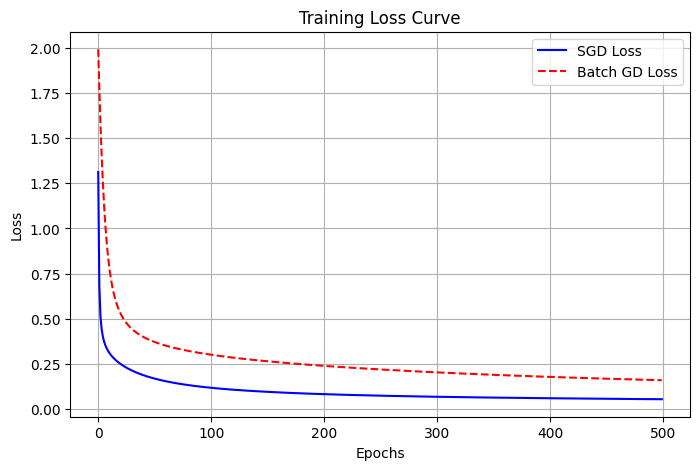

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(len(loss_history_sgd)), loss_history_sgd, label="SGD Loss", color='b', linestyle='-')
plt.plot(range(len(loss_gd)), loss_gd, label="Batch GD Loss", color='r', linestyle='--')

# Labels and Title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()
